In [1]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import json
import torch
import pickle
import configparser
from ast import literal_eval
from hiko.dask import daskify
from sklearn.metrics import accuracy_score, roc_auc_score
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

# Read in config
config = configparser.ConfigParser()
config.read('../ml_models_for_airflow/dbs3_config.ini')

db_engine = create_engine(config['AIRFLOW']['postgres_conn'])

pairs_mapping = literal_eval(config['MODEL']['pairs_mapping'])
pairs = tuple(pairs_mapping.values())

[I 2020-05-14 10:02:25,145] Finished trial#0 with value: 0.6128246753246753
with parameters: {'seq_length': 52, 'num_attention_heads': 6, 'num_transformer_blocks': 9,
                  'num_out_channels_emb': 191, 'dropout': 0.420575643690622, 'batch_size': 188, 'num_epochs': 125, 'optimizer': 'SGD', 'learning_rate': 7.245336658547346e-05}.
Best is trial#0 with value: 0.6128246753246753.

In [2]:
SEQ_LENGHT = 25
NUM_ATTENTION_HEADS = 1
NUM_TRANSFORMER_BLOCKS = 1
NUM_OUT_CHANNELS_EMB = 2000
DROPOUT = 0.420575643690622
BATCH_SIZE = 188
NUM_EPOCHS = 200
OPTIMIZER = 'SGD'
LEARNING_RATE = 7.245336658547346e-05
GRAD_CLIPPING_VAL = 1
INIT_LR = 10

In [3]:
from training_data_loader import Dataset
from torch.utils import data

In [4]:
from transformer import Transformer

In [5]:
full_data_set = Dataset(config_location='../ml_models_for_airflow/dbs3_config.ini',
                      pairs=pairs,
                      seq_lenght=SEQ_LENGHT,
                      num_features=2,
                      local_path='book_data_raw.csv')

In [6]:
len(full_data_set)

3889

In [7]:
train_set_size = int(len(full_data_set)*0.85)
test_set_size = len(full_data_set) - train_set_size

In [8]:
trainset, valset = data.random_split(full_data_set,
                                     [train_set_size, test_set_size]
                                    )

In [9]:
train_generator = data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_generator = data.DataLoader(valset, batch_size=len(valset), shuffle=True, num_workers=4)

In [10]:
transformer = Transformer(emb=SEQ_LENGHT,
                          heads=NUM_ATTENTION_HEADS,
                          depth=NUM_TRANSFORMER_BLOCKS,
                          num_features=2,
                          num_out_channels_emb=NUM_OUT_CHANNELS_EMB,
                          dropout=DROPOUT
                          )

In [11]:
if OPTIMIZER == 'ADAM': optimizer = torch.optim.Adam(transformer.parameters(), lr=LEARNING_RATE)
if OPTIMIZER == 'SGD': optimizer = torch.optim.SGD(transformer.parameters(), lr=LEARNING_RATE)

learning_rate_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda i: min(i / (INIT_LR / BATCH_SIZE), 1.0))

In [12]:
transformer.apply(Transformer.init_weights)

Transformer(
  (time_series_features_encoding): Conv1d(2, 2, kernel_size=(1,), stride=(1,), bias=False)
  (pos_embedding): Embedding(25, 25)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (tokeys): Linear(in_features=25, out_features=25, bias=False)
        (toqueries): Linear(in_features=25, out_features=25, bias=False)
        (tovalues): Linear(in_features=25, out_features=25, bias=False)
        (unifyheads): Linear(in_features=25, out_features=25, bias=True)
      )
      (norm1): LayerNorm((25,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((25,), eps=1e-05, elementwise_affine=True)
      (feed_forward_layers): Sequential(
        (0): Linear(in_features=25, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=25, bias=True)
      )
      (dropout): Dropout(p=0.420575643690622, inplace=False)
    )
  )
  (conv1d_for_embeddings): Conv1d(2, 2000, kernel_size=(1,),

In [13]:
criterion = torch.nn.BCELoss()
track_epoch_loss = []
train_auc = []
test_auc = []

In [14]:
for ep in range(NUM_EPOCHS):
    transformer.train()
    epoch_loss = 0
    temp_train_auc = 0
    
    for train_x, train_y in train_generator:
        
        predictions = transformer(train_x)
        loss = criterion(predictions, train_y.view(-1, 1))
        epoch_loss += loss.item()
        temp_train_auc += roc_auc_score(
            train_y.numpy(), predictions.detach().numpy())
        
        optimizer.zero_grad()
        loss.backward()
        
        # clip up
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), GRAD_CLIPPING_VAL)

        optimizer.step()
        learning_rate_scheduler.step()
    
    train_auc.append(temp_train_auc/len(train_generator))
    if ep % 10 == 0: print('train auc:', train_auc[-1], ' epoch:', ep)
    
    with torch.no_grad():
        transformer.eval()
        temp_test_auc = 0
        for test_x, test_y in test_generator:
            predictions = transformer(test_x)
            temp_test_auc += roc_auc_score(
                test_y.numpy(), predictions.numpy())

    test_auc.append(temp_test_auc/len(test_generator))
    if ep % 10 == 0: print('test auc:', test_auc[-1], ' epoch:', ep)

train auc: 0.4830993740701661  epoch: 0
test auc: 0.6034986634986634  epoch: 0
train auc: 0.49560759147132  epoch: 10
test auc: 0.6014612414612415  epoch: 10
train auc: 0.48780383810343714  epoch: 20
test auc: 0.5985328185328185  epoch: 20
train auc: 0.5025828513945838  epoch: 30
test auc: 0.5939055539055539  epoch: 30
train auc: 0.4932532825874331  epoch: 40
test auc: 0.5922542322542322  epoch: 40
train auc: 0.49844614859450076  epoch: 50
test auc: 0.5871101871101871  epoch: 50
train auc: 0.5039706761573381  epoch: 60
test auc: 0.5766973566973567  epoch: 60
train auc: 0.525148563017441  epoch: 70
test auc: 0.565981585981586  epoch: 70
train auc: 0.517604726851538  epoch: 80
test auc: 0.5484288684288684  epoch: 80
train auc: 0.4996958079409705  epoch: 90
test auc: 0.5272943272943273  epoch: 90
train auc: 0.5054479388776894  epoch: 100
test auc: 0.5207246807246807  epoch: 100
train auc: 0.48859431262016284  epoch: 110
test auc: 0.5197267597267597  epoch: 110
train auc: 0.511965870715235

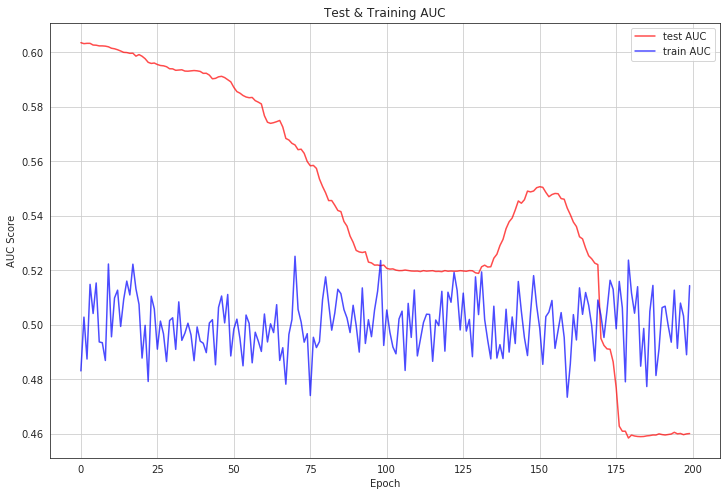

In [16]:
plt.figure(figsize=(12, 8))
plt.title('Test & Training AUC')
plt.plot(test_auc, label='test AUC', color='r', alpha=0.7)
plt.plot(train_auc, label='train AUC', color='b', alpha=0.7)
plt.ylabel('AUC Score')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()